## Phase 3 : Feature Engineering, création des variables pour la segmentation : Frequency, Recency & Monetary

In [10]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Load config
with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)


FILE_CLEAN_DATA = os.path.join("..", config["paths"]["processed_data"], config["files"]["data_clean"])
FILE_RFM_DATA = os.path.join("..", config["paths"]["intermediate_data"], config["files"]["data_rfm"])

In [11]:

# Load clean data
df = pd.read_csv(FILE_CLEAN_DATA)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### RFM ANALYSIS ###

#### Calcule Recency

In [12]:
# Calculate Recency
last_date = df['InvoiceDate'].max()
customer_max_date = df.groupby('CustomerID')['InvoiceDate'].max()
recency = (last_date - customer_max_date).dt.days


#### Calcule Frequency

In [13]:
# Calculate Frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

#### Calcule Monetary

In [14]:
# Calculate Monetary
# Calculate total amount by multiplying Quantity and UnitPrice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['TotalAmount'].sum()

#### Combiner les métriques RFM dans un seul dataframe

In [15]:
rfm_df = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

# Reset index to make CustomerID a column
rfm_df = rfm_df.reset_index()

# Save RFM features
rfm_df.to_csv(f"../{config['paths']['intermediate_data']}rfm_features.csv", index=False)

print("RFM features shape:", rfm_df.shape)
print("\nRFM features summary:")
print(rfm_df.describe())


RFM features shape: (4338, 4)

RFM features summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     306.482500
50%    15299.500000    50.000000     2.000000     668.570000
75%    16778.750000   141.000000     5.000000    1660.597500
max    18287.000000   373.000000   209.000000  280206.020000


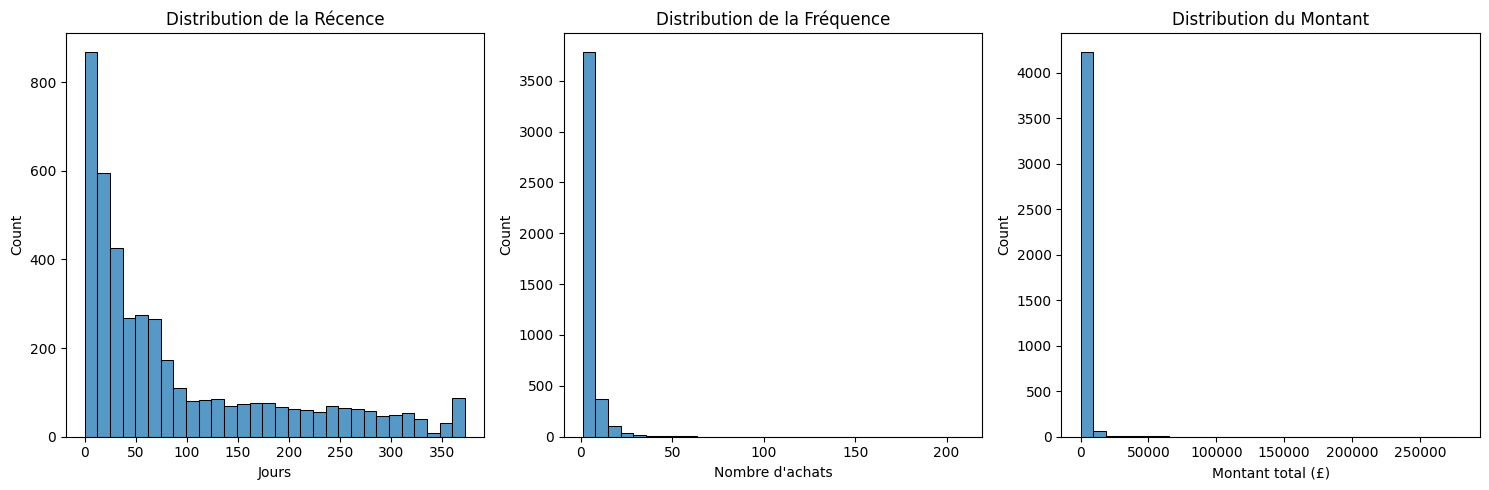

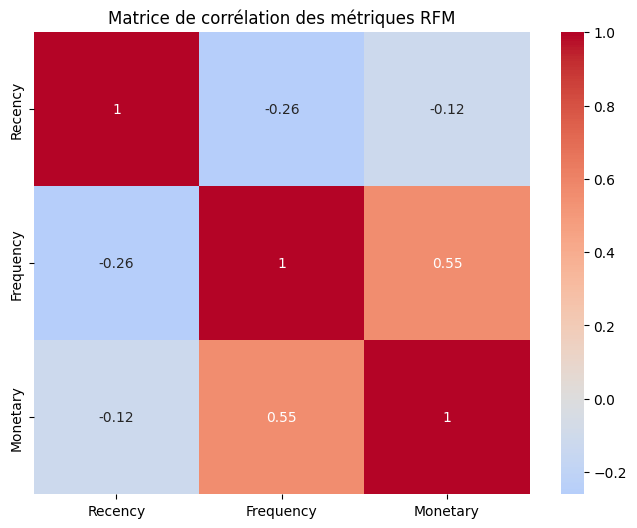

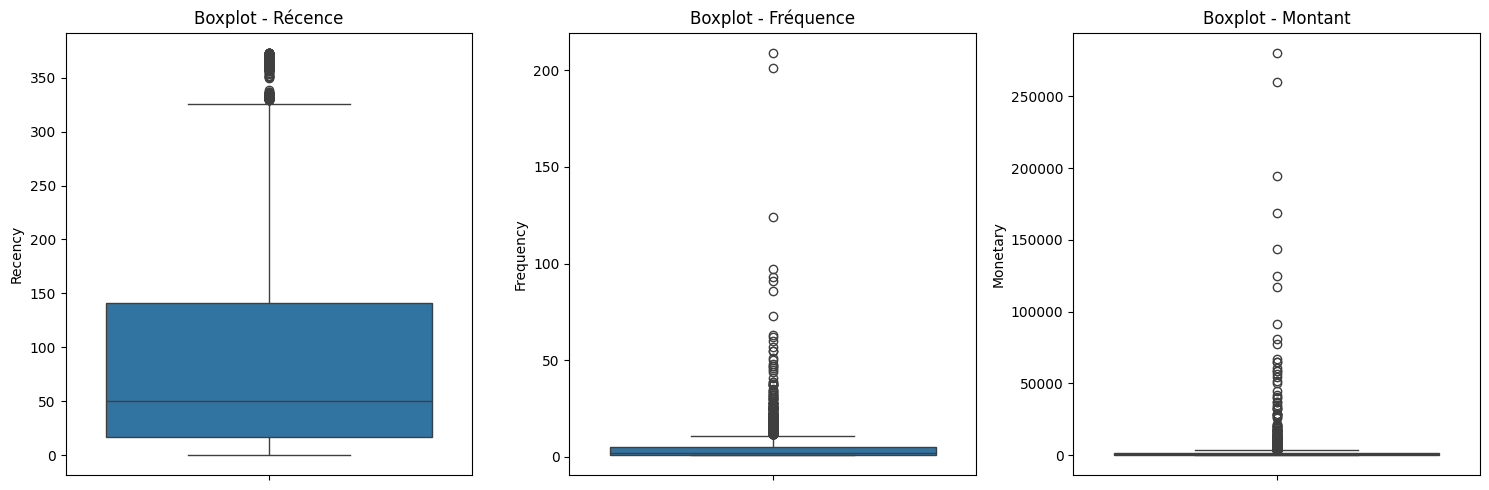

In [16]:
# Visualisation des distributions des métriques RFM
plt.figure(figsize=(15, 5))

# Recency distribution
plt.subplot(131)
sns.histplot(data=rfm_df, x='Recency', bins=30)
plt.title('Distribution de la Récence')
plt.xlabel('Jours')

# Frequency distribution 
plt.subplot(132)
sns.histplot(data=rfm_df, x='Frequency', bins=30)
plt.title('Distribution de la Fréquence')
plt.xlabel('Nombre d\'achats')

# Monetary distribution
plt.subplot(133)
sns.histplot(data=rfm_df, x='Monetary', bins=30)
plt.title('Distribution du Montant')
plt.xlabel('Montant total (£)')

plt.tight_layout()
plt.show()

# Visualisation des corrélations
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), 
            annot=True, 
            cmap='coolwarm',
            center=0)
plt.title('Matrice de corrélation des métriques RFM')
plt.show()

# Box plots pour détecter les outliers
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.boxplot(y=rfm_df['Recency'])
plt.title('Boxplot - Récence')

plt.subplot(132)
sns.boxplot(y=rfm_df['Frequency'])
plt.title('Boxplot - Fréquence')

plt.subplot(133)
sns.boxplot(y=rfm_df['Monetary'])
plt.title('Boxplot - Montant')

plt.tight_layout()
plt.show()


D'après les visualisations précédentes, nous pouvons faire plusieurs observations importantes :

1. Distributions :
   - Les trois métriques (Recency, Frequency, Monetary) présentent des distributions fortement asymétriques
   - Présence importante de valeurs extrêmes, particulièrement pour Frequency et Monetary

2. Corrélations :
   - Forte corrélation positive (0.55) entre Frequency et Monetary
   - Corrélations faibles à modérées avec Recency
   
3. Outliers :
   - Les box plots révèlent de nombreux outliers dans les trois métriques
   - Impact potentiel sur les analyses ultérieures

Conclusion pour la réduction des dimensions :
- La forte corrélation entre Frequency et Monetary suggère une redondance d'information
- Une réduction des dimensions (par exemple via PCA) pourrait être bénéfique pour :
  * Réduire la complexité du modèle
  * Gérer la colinéarité entre les variables
  * Faciliter la visualisation des segments de clients

Nous procéderons donc à une réduction des dimensions via PCA dans la suite de l'analyse.
